# Vizualizações dos dados de acidentes de trânsito no Brasil

Dados extraídos do site da ANTT (Agência Nacional de Transportes Terrestres) e disponibilizados no site [Dados Abertos](https://dados.antt.gov.br/group/rodovias) do governo brasileiro.

## 1. Imports

In [24]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import os
import folium
import calendar
from folium.plugins import HeatMap
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)

## 2. Abrindo os dados

Os dados estão separados por concessíonárias, cada CSV em "/data/ANTT/acidentes" apresenta dados de todos os acidentes que já aconteceram em um rodovia sob a concessão daquela concessionária.

In [25]:
dfs = {}
path = '../data/ANTT/acidentes'

for file in os.listdir(path):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(path, file), sep=';', encoding='latin1')
        concessionaria = file.split('_')[2][:-4]
        dfs[concessionaria] = df

dfs

{'viabrasil':             data   horario  n_da_ocorrencia tipo_de_ocorrencia       km  \
 0     19/11/2022  11:14:00               67         AC03-ACIDE  598.415   
 1     19/11/2022  11:36:00               70         AC02-ACIDE  272.273   
 2     19/11/2022  07:56:00              132         AC03-ACIDE     1034   
 3     19/11/2022  11:14:00              143         AC03-ACIDE      517   
 4     19/11/2022  11:49:00              142         AC03-ACIDE   65.129   
 ...          ...       ...              ...                ...      ...   
 1956  30/07/2024  04:52:00              114         Sem vítima  514,000   
 1957  30/07/2024  05:13:00              122         Sem vítima  1054,00   
 1958  31/07/2024  06:11:00              138         Com vítima  1102,10   
 1959  31/07/2024  09:20:00              165         Com vítima  893,932   
 1960  31/07/2024  01:27:00              189         Sem vítima  587,300   
 
          trecho      sentido     tipo_de_acidente  automovel  bicicleta 

Filtrando os dados apenas de 2020 a 2024, por serem mais recentes.

In [26]:
# datas para datetime
filter_dfs = []
for key, df in dfs.items():
    df['concessionaria'] = key
    df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y')
    df['data_hora'] = pd.to_datetime(df['data'].astype(str) + ' ' + df['horario'], format='%Y-%m-%d %H:%M:%S')
    df['com_vitima'] = True if df['tipo_de_ocorrencia'].str.contains('com').any() else False
    df.drop(columns=['tipo_de_ocorrencia','data','horario'], inplace=True)
    df = df[df['data_hora'].dt.year >= 2020]
    filter_dfs.append(df)

acidentes_df = pd.concat(filter_dfs, ignore_index=True)
print(acidentes_df.info())
print(acidentes_df.head())
print(acidentes_df.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293344 entries, 0 to 293343
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   n_da_ocorrencia                 293344 non-null  object        
 1   km                              293344 non-null  object        
 2   trecho                          293344 non-null  object        
 3   sentido                         293341 non-null  object        
 4   tipo_de_acidente                293102 non-null  object        
 5   automovel                       293344 non-null  int64         
 6   bicicleta                       293344 non-null  int64         
 7   caminhao                        293344 non-null  int64         
 8   moto                            293344 non-null  int64         
 9   onibus                          293344 non-null  int64         
 10  outros                          293344 non-null  int64  

Limpando os dados, pois em alguns casos existem "*typos*"

In [27]:
import re
def limpar_string(valor):
    if isinstance(valor, str): # apenas limpa oq não é possivel identificar como float, ou seja, contém algum erro
        valor_limpo = re.sub(r'[^\d.]', '', valor) 
        return valor_limpo
    return valor

# funcação necessária pq tinham valores com vírgula, ponto e erros grotescos como:
# "263+289" | "a675,812"
acidentes_df['km'] = acidentes_df['km'].apply(limpar_string)
acidentes_df['km'] = acidentes_df['km'].astype(float)
print(acidentes_df['km'].describe())
print(acidentes_df.info())
print("O DataFrame Final possui {} linhas e {} colunas".format(acidentes_df.shape[0], acidentes_df.shape[1]))

count    293344.000000
mean      26064.260622
std      111531.028151
min           0.000000
25%         113.000000
50%         300.000000
75%         567.200000
max      996609.000000
Name: km, dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293344 entries, 0 to 293343
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   n_da_ocorrencia                 293344 non-null  object        
 1   km                              293344 non-null  float64       
 2   trecho                          293344 non-null  object        
 3   sentido                         293341 non-null  object        
 4   tipo_de_acidente                293102 non-null  object        
 5   automovel                       293344 non-null  int64         
 6   bicicleta                       293344 non-null  int64         
 7   caminhao                        293344 non-null  int64

## 3. Explorando os dados

### Acidentes por concessárionária

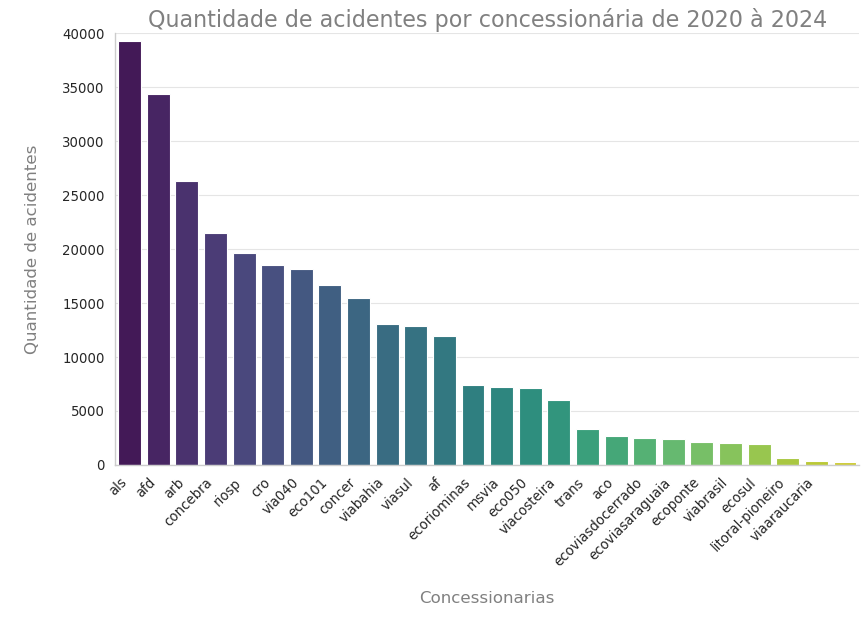

In [28]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=80)

sns.set_theme(style='whitegrid')
ax = sns.barplot(x=acidentes_df['concessionaria'].value_counts().index, 
                 y=acidentes_df['concessionaria'].value_counts().values, 
                 palette='viridis')
plt.title('Quantidade de acidentes por concessionária de 2020 à 2024', fontsize=20, color='gray')

# total = df_final.shape[0]
# for i in ax.patches:
#     ax.text(i.get_x()+0.03, i.get_height() - 1500, 
#             str(round((i.get_height()/total)*100, 2))+"%", 
#             ha='center', 
#             fontsize=12,
#             weight='bold',
#             color='white')

plt.xlabel('\nConcessionarias\n', fontsize=15, color='gray')
plt.ylabel('\nQuantidade de acidentes\n', fontsize=15, color='gray')

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0, 40000)

plt.grid(axis='y', alpha=0.5)

# for i in ['bottom', 'left']:
#     ax.spines[i].set_color('white')
#     ax.spines[i].set_linewidth(1.5)

right_side = ax.spines["right"]
right_side.set_visible(False)

top_side = ax.spines["top"]
top_side.set_visible(False)

plt.savefig('../output/quantidade_acidentes_concessionaria.png', bbox_inches='tight', dpi=300, transparent=True)

### Acidentes por trecho

#### Rodovias mais perigosas

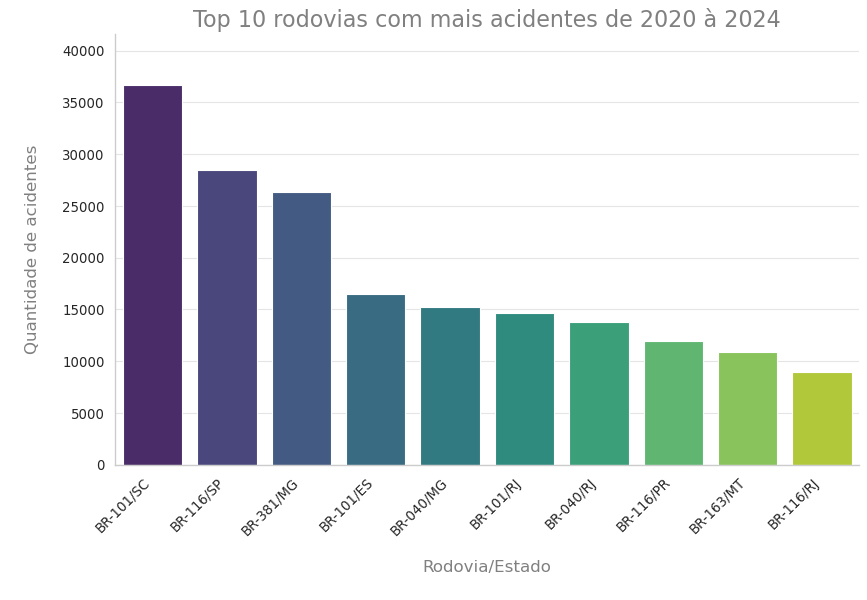

In [29]:
## Top 10 rodovias mais perigosas
rodovias_mais_perigosas = acidentes_df['trecho'].value_counts().head(10)

fig, ax = plt.subplots(figsize=(12, 7), dpi=80)
sns.set_theme(style='whitegrid')
ax = sns.barplot(x=rodovias_mais_perigosas.index, 
                 y=rodovias_mais_perigosas.values, 
                 palette='viridis')
plt.title('Top 10 rodovias com mais acidentes de 2020 à 2024', fontsize=20, color='gray')

plt.xlabel('\nRodovia/Estado\n', fontsize=15, color='gray')
plt.ylabel('\nQuantidade de acidentes\n', fontsize=15, color='gray')

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0, rodovias_mais_perigosas.values.max() + 5000)

plt.grid(axis='y', alpha=0.5)

right_side = ax.spines["right"]
right_side.set_visible(False)

top_side = ax.spines["top"]
top_side.set_visible(False)

plt.savefig('../output/rodovias_mais_perigosas.png', bbox_inches='tight', dpi=300, transparent=True)

#### KM mais perigosos

In [30]:
## Top 10 trechos mais perigosos
km_mais_perigosos = acidentes_df.groupby(['trecho', 'km']).size().reset_index(name='quantidade_acidentes')
km_mais_perigosos = km_mais_perigosos.sort_values(by='quantidade_acidentes', ascending=False).head(10)
km_mais_perigosos

,trecho,km,quantidade_acidentes
7309,BR-040/RJ,93.0,790
7307,BR-040/RJ,91.0,667
7300,BR-040/RJ,84.0,513
7310,BR-040/RJ,94.0,503
7308,BR-040/RJ,92.0,488
7306,BR-040/RJ,90.0,457
7329,BR-040/RJ,113.0,412
7294,BR-040/RJ,78.0,363
7301,BR-040/RJ,85.0,325
7339,BR-040/RJ,123.0,318


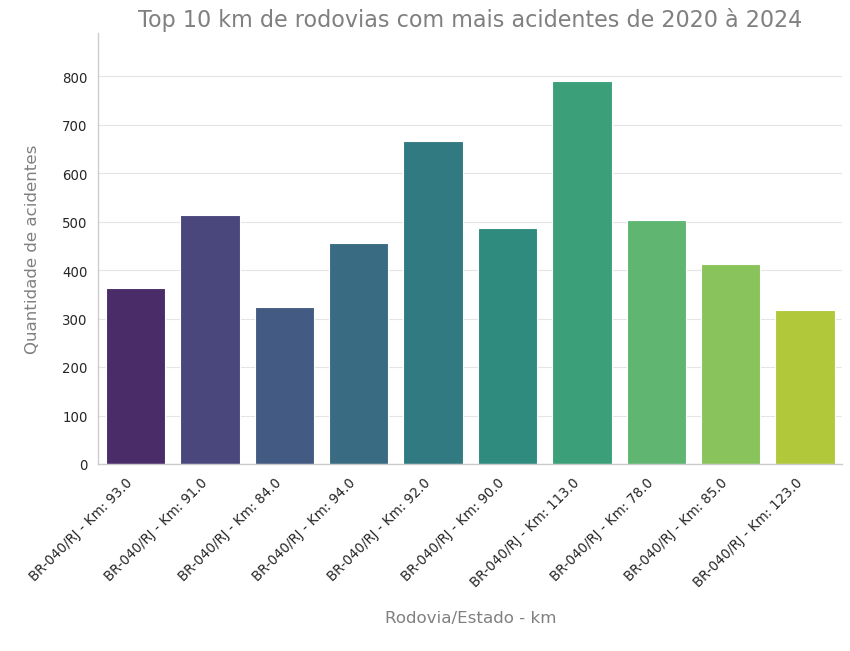

In [31]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=80)
sns.set_theme(style='whitegrid')
ax = sns.barplot(x=km_mais_perigosos['km'], 
                 y=km_mais_perigosos['quantidade_acidentes'], 
                 palette='viridis')
plt.title('Top 10 km de rodovias com mais acidentes de 2020 à 2024', fontsize=20, color='gray')

plt.xlabel('\nRodovia/Estado - km\n', fontsize=15, color='gray')
plt.ylabel('\nQuantidade de acidentes\n', fontsize=15, color='gray')

plt.xticks(ticks=range(0, km_mais_perigosos.shape[0]),
           labels=km_mais_perigosos['trecho'] + ' - Km: ' + km_mais_perigosos['km'].astype(str),
           rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0, km_mais_perigosos['quantidade_acidentes'].max() + 100)

plt.grid(axis='y', alpha=0.5)

right_side = ax.spines["right"]
right_side.set_visible(False)

top_side = ax.spines["top"]
top_side.set_visible(False)

plt.savefig('../output/km_mais_perigosos.png', bbox_inches='tight', dpi=300, transparent=True)

### Acidentes por estado

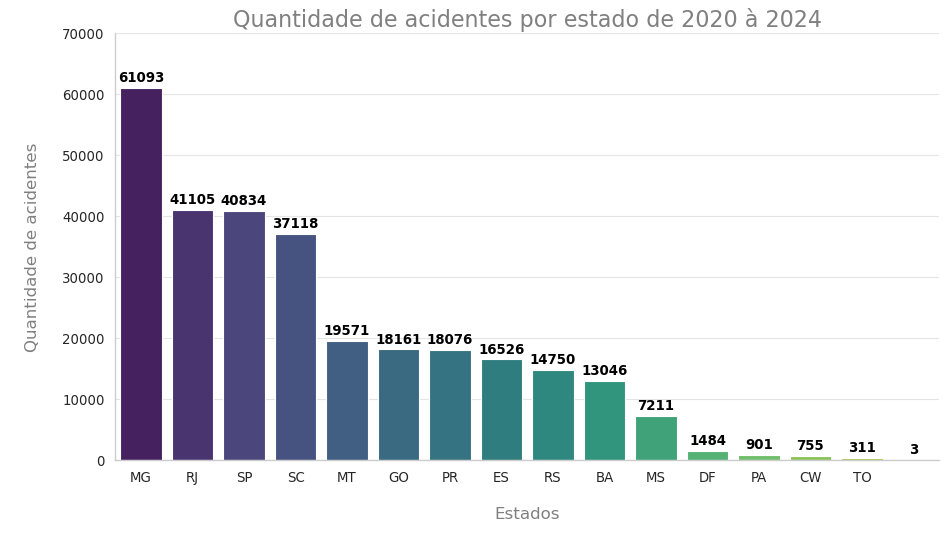

In [32]:
acidentes_df['estado'] = acidentes_df['trecho'].str.split('/').str[1]
acidentes_df.head(1)

fig, ax = plt.subplots(figsize=(12, 7), dpi=80)

sns.set_theme(style='whitegrid')
ax = sns.barplot(x=acidentes_df['estado'].value_counts().index, y=acidentes_df['estado'].value_counts().values, palette='viridis')
plt.title('Quantidade de acidentes por estado de 2020 à 2024', fontsize=20, color='gray')


for i in ax.patches:
    ax.text(i.get_x()+0.4, i.get_height() + 1000, 
            str(int(i.get_height())), 
            ha='center', 
            fontsize=12,
            weight='bold',
            color='black')

plt.xlabel('\nEstados\n', fontsize=15, color='gray')
plt.ylabel('\nQuantidade de acidentes\n', fontsize=15, color='gray')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0, 70000)

plt.grid(axis='y', alpha=0.5)

# for i in ['bottom', 'left']:
#     ax.spines[i].set_color('white')
#     ax.spines[i].set_linewidth(1.5)

right_side = ax.spines["right"]
right_side.set_visible(False)

top_side = ax.spines["top"]
top_side.set_visible(False)

plt.tight_layout()

plt.savefig('../output/quantidade_acidentes_estado.png', bbox_inches='tight', dpi=300, transparent=True)

### Acidentes com ou sem vítimas

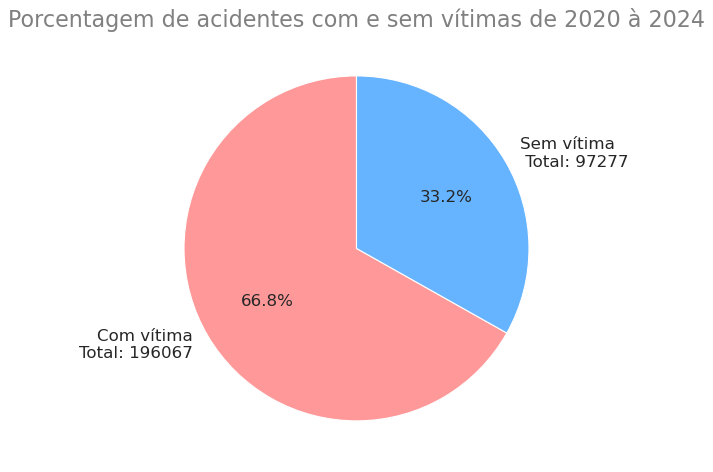

In [33]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=80)

total_sem_vitimas = acidentes_df['com_vitima'].sum()
total_vitimas = acidentes_df.shape[0] - total_sem_vitimas

ax = plt.pie(acidentes_df['com_vitima'].value_counts(), 
             labels=[ f'Com vítima\nTotal: {total_sem_vitimas}', f'Sem vítima\n Total: {total_vitimas}',], 
             autopct='%1.1f%%', 
             startangle=90, 
             colors=['#ff9999','#66b3ff'], 
             textprops={'fontsize': 15})

plt.title('Porcentagem de acidentes com e sem vítimas de 2020 à 2024', fontsize=20, color='gray')

plt.savefig('../output/porcentagem_acidentes_vitimas.png', bbox_inches='tight', dpi=300, transparent=True)

### Acidentes por Ano

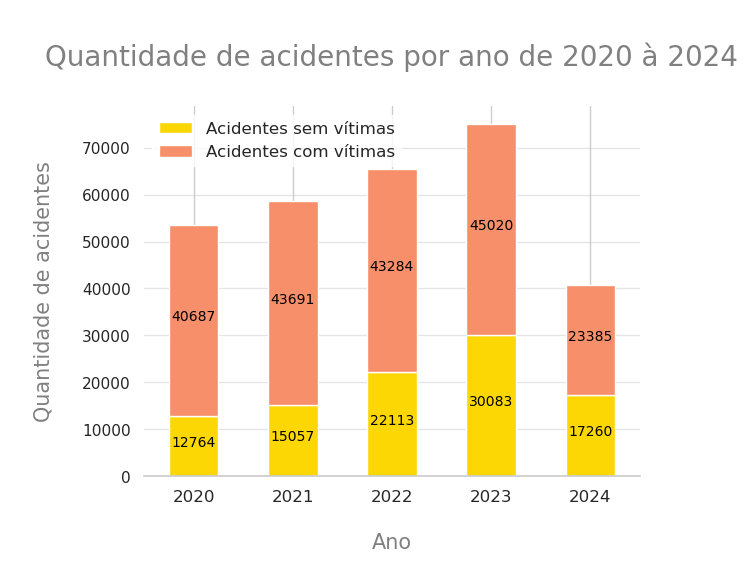

In [34]:
acidentes_df['ano'] = acidentes_df['data_hora'].dt.year

acidentes_com_vitima_ano = acidentes_df.groupby(['ano', 'com_vitima']).size().unstack()
acidentes_com_vitima_ano

# ax = sns.barplot(x=df_final['data_hora'].dt.year.value_counts().index, 
#                  y=df_final['data_hora'].dt.year.value_counts().values, 
#                  color='#fcd703')

ax = acidentes_com_vitima_ano.plot(kind='bar', color=['#fcd703', '#f68f6a'], label='Acidentes com vítimas', stacked=True)

plt.title('\nQuantidade de acidentes por ano de 2020 à 2024\n', fontsize=20, color='gray')

for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy()
    ax.text(x+width/2, y+height/2, 
            str(int(height)), 
            ha='center', 
            fontsize=10,
            color='black')
    
for i in ['top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)

plt.xlabel('\nAno\n', fontsize=15, color='gray')
plt.ylabel('\nQuantidade de acidentes\n', fontsize=15, color='gray')

plt.xticks(fontsize=12, rotation=0)

plt.grid(axis='y', alpha=0.5)

plt.legend(['Acidentes sem vítimas','Acidentes com vítimas'], fontsize=12, edgecolor='white', fancybox=True, loc='best')

plt.savefig('../output/acidentes_por_ano.png', dpi=300, bbox_inches='tight')

### Acidentes por mês

In [35]:
acidentes_df['mes'] = acidentes_df['data_hora'].dt.month
meses_do_ano = [calendar.month_abbr[i] for i in range(1, 13)]

acidentes_com_vitima_mes = acidentes_df.groupby(['mes', 'com_vitima']).size().unstack()
acidentes_com_vitima_mes

com_vitima,False,True
mes,,
1,8148,20269
2,7505,16712
3,7871,16362
4,8882,15411
5,9580,15955
6,9126,16497
7,9217,16884
8,6598,14177
9,6744,14127


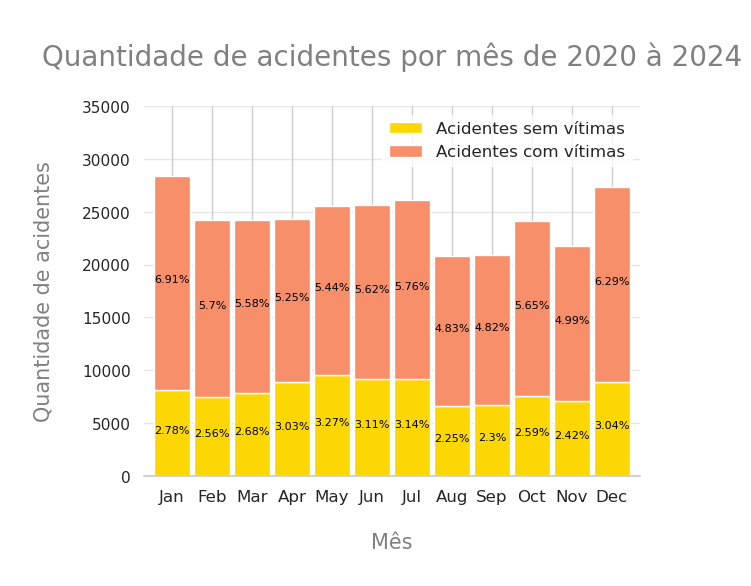

In [36]:
# ax = sns.barplot(x=df_final['data_hora'].dt.year.value_counts().index, 
#                  y=df_final['data_hora'].dt.year.value_counts().values, 
#                  color='#fcd703')

ax = acidentes_com_vitima_mes.plot(kind='bar', color=['#fcd703', '#f68f6a'], label='Acidentes com vítimas', stacked=True, width=0.9)

plt.title('\nQuantidade de acidentes por mês de 2020 à 2024\n', fontsize=20, color='gray')

total = acidentes_df.shape[0]
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy()
    ax.text(x+width/2, y+height/2, 
            f'{round(height*100/total, 2)}%', 
            ha='center', 
            fontsize=8,
            color='black')
    
for i in ['top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)

plt.xlabel('\nMês\n', fontsize=15, color='gray')
plt.ylabel('\nQuantidade de acidentes\n', fontsize=15, color='gray')

plt.grid(axis='y', alpha=0.5)

plt.ylim(0, 35000)

plt.xticks(range(0, 12), meses_do_ano, fontsize=12, rotation=0)

plt.legend(['Acidentes sem vítimas','Acidentes com vítimas'], fontsize=12, edgecolor='white', fancybox=True, loc='best')

plt.savefig('../output/acidentes_por_mes.png', dpi=300, bbox_inches='tight')

### Acidentes por dia da semana

In [37]:
dia_semana_df = pd.DataFrame(acidentes_df['data_hora'].dt.day_name().value_counts()).reset_index().rename(columns={'data_hora':'dia_semana'})
print(dia_semana_df.columns)

nome_dias = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
dias_ordenados = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

dia_semana_df['dia_semana'] = pd.Categorical(dia_semana_df['dia_semana'], categories=dias_ordenados, ordered=True)
dia_semana_df = dia_semana_df.sort_values('dia_semana')
dia_semana_df['dia_semana'] = nome_dias
dia_semana_df

Index(['dia_semana', 'count'], dtype='object')


,dia_semana,count
3,Segunda-feira,41452
6,Terça-feira,37570
5,Quarta-feira,38336
4,Quinta-feira,39703
0,Sexta-feira,47642
1,Sábado,44714
2,Domingo,43927


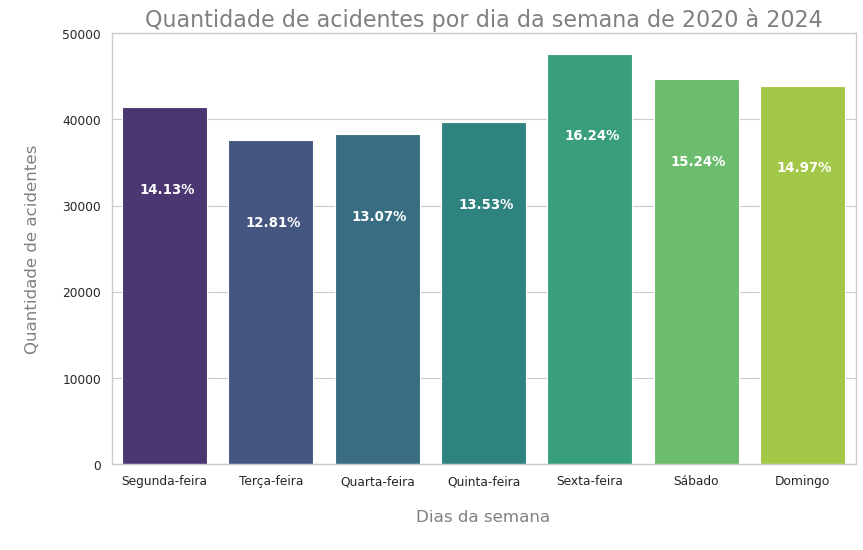

In [38]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=80)

sns.set_theme(style='whitegrid')
ax = sns.barplot(x=dia_semana_df['dia_semana'], y=dia_semana_df['count'], palette='viridis')

total = acidentes_df.shape[0]
for i in ax.patches:
    height = i.get_height()
    ax.text(i.get_x()+0.42, i.get_height() + -10000, 
            f'{round(height*100/total, 2)}%', 
            ha='center', 
            fontsize=12,
            weight='bold',
            color='white')

plt.title('Quantidade de acidentes por dia da semana de 2020 à 2024', fontsize=20, color='gray')
plt.xlabel('\nDias da semana\n', fontsize=15, color='gray')
plt.ylabel('\nQuantidade de acidentes\n', fontsize=15, color='gray')
# plt.xticks(range(0, 7), nome_dias, fontsize=12)
plt.savefig('../output/quantidade_acidentes_dia_semana.png', bbox_inches='tight', dpi=300, transparent=True)

### Acidentes por hora

In [39]:
hora_df = pd.DataFrame(acidentes_df['data_hora'].dt.hour.value_counts()).reset_index().rename(columns={'data_hora':'hora'}).sort_values('hora')
print(hora_df.columns)
acidentes_df['data_hora'].dt.hour.value_counts()
print(acidentes_df.shape[0], hora_df['count'].sum())

Index(['hora', 'count'], dtype='object')
293344 293344


/tmp/ipykernel_613230/986395835.py:12: UserWarning: The palette list has more values (24) than needed (12), which may not be intended.
  ax = sns.barplot(x=hora_df['hora'], y=hora_df['count'], palette=cores)


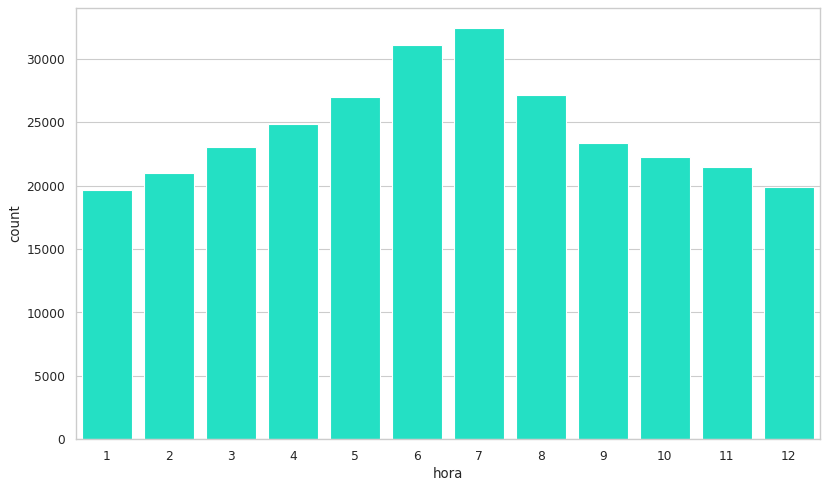

In [40]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=80)

cores = []
for i in range(24):
    if i >= 0 and i < 12:
        cores.append('#05ffda')
    elif i >= 12 and i < 18:
        cores.append('#2426b3')
    else:
        cores.append('#fcd703')

ax = sns.barplot(x=hora_df['hora'], y=hora_df['count'], palette=cores)
plt.show()

#### Observação:

Aqui os dados estão no formato 12 horas, porém sem a especificação de AM ou PM, então não é possível saber se a hora é de manhã ou de tarde.

## Cruzando a pista com mais acidentes com as posições geográficas

*Feito em outro notebook, apenas copiando o código*

Os dados das pistas estão em um unico CSV, em "/data/ANTT/km_pista_principal".

### Abrindo os dados das pistas

In [41]:
pista_principal_df = pd.read_csv('../data/ANTT/km_pista_principal/dados_dos_quilometro_principal.csv', sep=';', encoding='latin1')
pista_principal_df['latitude'] = pista_principal_df['latitude'].str.replace(',', '.').astype(float)
pista_principal_df['longitude'] = pista_principal_df['longitude'].str.replace(',', '.').astype(float)
pista_principal_df['km'] = pista_principal_df['km_m'].str.replace(',', '.').astype(float)
pista_principal_df.drop(columns=['km_m'], inplace=True)

In [ ]:
br101_geral_df = pista_principal_df[pista_principal_df['rodovia'].str.startswith('BR-101')].reset_index(drop=True)
br101_geral_df.sort_values(['rodovia', 'km', 'sentido'])
br101_geral_df.reset_index(drop=True)
br101_geral_df.to_csv('../data/DATA_FUSION/BR101-Geral/br101_pista.csv', index=False)
print(br101_geral_df.head())
print(br101_geral_df.info())

         concessionaria  ano_do_pnv_snv    rodovia      sentido   latitude  \
0  AUTOPISTA FLUMINENSE            2019  BR-101/RJ  Decrescente -21.222611   
1  AUTOPISTA FLUMINENSE            2019  BR-101/RJ  Decrescente -21.222937   
2  AUTOPISTA FLUMINENSE            2019  BR-101/RJ  Decrescente -21.224398   
3  AUTOPISTA FLUMINENSE            2019  BR-101/RJ  Decrescente -21.226103   
4  AUTOPISTA FLUMINENSE            2019  BR-101/RJ  Decrescente -21.227435   

   longitude   km  
0 -41.309475  0.0  
1 -41.309895  0.2  
2 -41.310997  0.4  
3 -41.311632  0.6  
4 -41.312880  0.8  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64297 entries, 0 to 64296
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   concessionaria  64297 non-null  object 
 1   ano_do_pnv_snv  64297 non-null  int64  
 2   rodovia         64297 non-null  object 
 3   sentido         64297 non-null  object 
 4   latitude        64297 non-nu

In [ ]:
br101sc_pista_df = pista_principal_df[pista_principal_df['rodovia'] == 'BR-101/SC']
print(br101sc_pista_df.head())
print(br101sc_pista_df.info())
br101sc_pista_max_km, br101sc_pista_min_km = br101sc_pista_df['km'].max(), br101sc_pista_df['km'].min()
print("Max ->", br101sc_pista_max_km, " Min ->", br101sc_pista_min_km)

             concessionaria  ano_do_pnv_snv    rodovia    sentido   latitude  \
8933  AUTOPISTA LITORAL SUL            2009  BR-101/SC  Crescente -25.981624   
8934  AUTOPISTA LITORAL SUL            2009  BR-101/SC  Crescente -25.981790   
8935  AUTOPISTA LITORAL SUL            2009  BR-101/SC  Crescente -25.982570   
8936  AUTOPISTA LITORAL SUL            2009  BR-101/SC  Crescente -25.983410   
8937  AUTOPISTA LITORAL SUL            2009  BR-101/SC  Crescente -25.984280   

      longitude   km  
8933 -48.886367  0.0  
8934 -48.886230  0.1  
8935 -48.885720  0.2  
8936 -48.885360  0.3  
8937 -48.885140  0.4  
<class 'pandas.core.frame.DataFrame'>
Index: 6876 entries, 8933 to 250382
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   concessionaria  6876 non-null   object 
 1   ano_do_pnv_snv  6876 non-null   int64  
 2   rodovia         6876 non-null   object 
 3   sentido         6876 non-null   object 
 4   

### Pista para gdf

In [ ]:
from shapely.geometry import LineString

br101sc_pista_gdf = gpd.GeoDataFrame(
    br101sc_pista_df,
    geometry=gpd.points_from_xy(br101sc_pista_df.longitude, br101sc_pista_df.latitude),
    crs="EPSG:4326"
)

br101sc_pista_gdf = br101sc_pista_gdf.sort_values(by=['sentido', 'km'])
lines = br101sc_pista_gdf.groupby('sentido').apply(lambda x: LineString(x.geometry.tolist()))
br101sc_linhas_gdf = gpd.GeoDataFrame(lines, columns=['geometry']).reset_index()

print(br101sc_linhas_gdf.head())
br101sc_linhas_gdf.to_file('../data/ANTT/BR-101-SC/br101sc_pista_principal.geojson', driver='GeoJSON')

       sentido                                           geometry
0    Crescente  LINESTRING (-48.88637 -25.98162, -48.88623 -25...
1  Decrescente  LINESTRING (-48.88637 -25.98162, -48.88594 -25...


/tmp/ipykernel_2284981/3170160535.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lines = br101sc_pista_gdf.groupby('sentido').apply(lambda x: LineString(x.geometry.tolist()))


### Corrigindo os "km" dos acidentes

In [ ]:
br101sc_acidentes_df = acidentes_df[acidentes_df['trecho'].str.contains('BR-101/SC')]

print(br101sc_acidentes_df.info())
print(br101sc_acidentes_df['km'].max(), br101sc_acidentes_df['km'].min())
print(br101sc_acidentes_df['km'].describe())

br101sc_acidentes_df['km'] = br101sc_acidentes_df['km'].apply(lambda x: x / 1000 if x > br101sc_pista_max_km else x)

print(br101sc_acidentes_df['km'].max(), br101sc_acidentes_df['km'].min())
print(br101sc_acidentes_df['km'].describe())


<class 'pandas.core.frame.DataFrame'>
Index: 36645 entries, 1961 to 220447
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   n_da_ocorrencia                 36645 non-null  object        
 1   km                              36645 non-null  float64       
 2   trecho                          36645 non-null  object        
 3   sentido                         36645 non-null  object        
 4   tipo_de_acidente                36617 non-null  object        
 5   automovel                       36645 non-null  int64         
 6   bicicleta                       36645 non-null  int64         
 7   caminhao                        36645 non-null  int64         
 8   moto                            36645 non-null  int64         
 9   onibus                          36645 non-null  int64         
 10  outros                          36645 non-null  int64         
 11  tra

/tmp/ipykernel_2284981/2274209686.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br101sc_acidentes_df['km'] = br101sc_acidentes_df['km'].apply(lambda x: x / 1000 if x > br101sc_pista_max_km else x)


In [82]:
br101_acidentes_df = acidentes_df[acidentes_df['trecho'].str.contains('BR-101')]

print(br101_acidentes_df.info())
print(br101_acidentes_df['km'].max(), br101_acidentes_df['km'].min())
print(br101_acidentes_df['km'].describe())

for trecho in br101_acidentes_df['trecho'].unique():
    pista_max_km = br101_geral_df[br101_geral_df['rodovia'] == trecho]['km'].max()
    for index, row in br101_acidentes_df[br101_acidentes_df['trecho'] == trecho].iterrows():
        br101_acidentes_df.at[index, 'km'] = row['km'] / 1000 if row['km'] > pista_max_km else row['km']


print(br101_acidentes_df['km'].max(), br101_acidentes_df['km'].min())
print(br101_acidentes_df['km'].describe())

<class 'pandas.core.frame.DataFrame'>
Index: 70401 entries, 1961 to 280857
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   n_da_ocorrencia                 70401 non-null  object        
 1   km                              70401 non-null  float64       
 2   trecho                          70401 non-null  object        
 3   sentido                         70399 non-null  object        
 4   tipo_de_acidente                70356 non-null  object        
 5   automovel                       70401 non-null  int64         
 6   bicicleta                       70401 non-null  int64         
 7   caminhao                        70401 non-null  int64         
 8   moto                            70401 non-null  int64         
 9   onibus                          70401 non-null  int64         
 10  outros                          70401 non-null  int64         
 11  tra

In [85]:
print(br101_acidentes_df['sentido'].value_counts())

sentido_map = {
    'Norte': 'Crescente',
    'Sul': 'Decrescente',
    'Pista Norte': 'Crescente',
    'Pista Sul': 'Decrescente',
    'Crescente': 'Crescente',
    'Decrescente': 'Decrescente',
    'Norte/Sul': 'Decrescente'
}

br101_acidentes_df['sentido'] = br101_acidentes_df['sentido'].map(sentido_map)
ambos_df = br101_acidentes_df[br101_acidentes_df['sentido'] == 'Norte/Sul']

crescentes_df = ambos_df.copy()
crescentes_df['sentido'] = 'Crescente'
decrescentes_df = ambos_df.copy()
decrescentes_df['sentido'] = 'Decrescente'

br101_acidentes_df = pd.concat([br101_acidentes_df[br101_acidentes_df['sentido'] != 'Ambos'], crescentes_df, decrescentes_df], ignore_index=True)

print("\n\n")
print(br101_acidentes_df['sentido'].value_counts())

sentido
Decrescente    35938
Crescente      34352
Name: count, dtype: int64



sentido
Decrescente    35938
Crescente      34352
Name: count, dtype: int64


In [86]:
br101_acidentes_df.to_csv('../data/DATA_FUSION/BR101-Geral/br101_acidentes.csv', index=False)

In [ ]:
print(br101sc_acidentes_df['sentido'].value_counts())

sentido_map = {
    'Norte': 'Crescente',
    'Sul': 'Decrescente',
    'Crescente': 'Crescente',
    'Decrescente': 'Decrescente',
    'Norte/Sul': 'Decrescente'
}

# Substituindo os valores no DataFrame
br101sc_acidentes_df['sentido'] = br101sc_acidentes_df['sentido'].replace(sentido_map)
ambos_df = br101sc_acidentes_df[br101sc_acidentes_df['sentido'] == 'Ambos']

crescentes_df = ambos_df.copy()
crescentes_df['sentido'] = 'Crescente'

decrescentes_df = ambos_df.copy()
decrescentes_df['sentido'] = 'Decrescente'

br101sc_acidentes_df = pd.concat([
    br101sc_acidentes_df[br101sc_acidentes_df['sentido'] != 'Ambos'],
    crescentes_df,
    decrescentes_df
], ignore_index=True)

print("\n\n",br101sc_acidentes_df['sentido'].value_counts())

sentido
Sul            17608
Norte          16478
Crescente       1246
Decrescente     1232
Ambos             77
Norte/Sul          4
Name: count, dtype: int64


 sentido
Decrescente    18921
Crescente      17801
Name: count, dtype: int64


/tmp/ipykernel_2284981/2812179524.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  br101sc_acidentes_df['sentido'] = br101sc_acidentes_df['sentido'].replace(sentido_map)


In [ ]:
br101sc_acidentes_df.to_csv('../data/ANTT/BR-101-SC/acidentes_br101sc.csv', index=False)

### Fazendo o merge dos dados

In [ ]:
def arredondar_par(num):
    arredondado = round(num, 1)
    return arredondado + (1 if arredondado > 0 and arredondado % 2 != 0 else -1 if arredondado < 0 and arredondado % 2 != 0 else 0)

#colocar a lat e long do acidente
br101sc_acidentes_df['km'] = br101sc_acidentes_df['km'].apply(arredondar_par)
br101sc_acidentes_geo_df = pd.merge(br101sc_acidentes_df, br101sc_pista_df[['km', 'sentido', 'latitude', 'longitude']], on=['km', 'sentido'], how='left')

print(br101sc_acidentes_geo_df.columns)
print(br101sc_acidentes_geo_df['sentido'].value_counts())

Index(['n_da_ocorrencia', 'km', 'trecho', 'sentido', 'tipo_de_acidente',
       'automovel', 'bicicleta', 'caminhao', 'moto', 'onibus', 'outros',
       'tracao_animal', 'transporte_de_cargas_especiais', 'trator_maquinas',
       'utilitarios', 'ilesos', 'levemente_feridos', 'moderadamente_feridos',
       'gravemente_feridos', 'mortos', 'concessionaria', 'data_hora',
       'com_vitima', 'estado', 'ano', 'mes', 'latitude', 'longitude'],
      dtype='object')
sentido
Decrescente    18921
Crescente      17801
Name: count, dtype: int64


### Transformando em GeoDataFrame

In [ ]:
br101sc_acidentes_gdf = gpd.GeoDataFrame(br101sc_acidentes_geo_df, crs='EPSG:4326', geometry=gpd.points_from_xy(br101sc_acidentes_geo_df['longitude'], br101sc_acidentes_geo_df['latitude']))

print(br101sc_acidentes_gdf.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 36722 entries, 0 to 36721
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   n_da_ocorrencia                 36722 non-null  object        
 1   km                              36722 non-null  float64       
 2   trecho                          36722 non-null  object        
 3   sentido                         36722 non-null  object        
 4   tipo_de_acidente                36694 non-null  object        
 5   automovel                       36722 non-null  int64         
 6   bicicleta                       36722 non-null  int64         
 7   caminhao                        36722 non-null  int64         
 8   moto                            36722 non-null  int64         
 9   onibus                          36722 non-null  int64         
 10  outros                          36722 non-null  int64         

### Plot da pista e acidentes BR101/SC


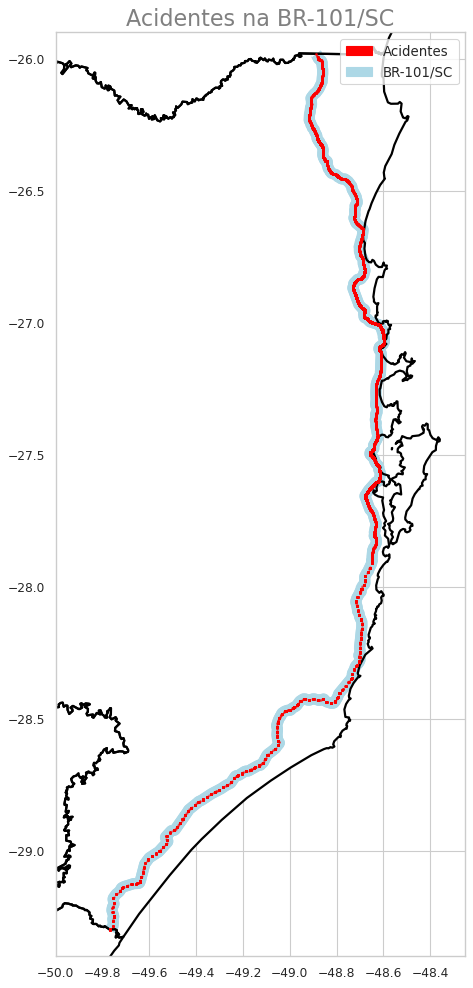

In [ ]:
url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
br_states = gpd.read_file(url)

fig, ax = plt.subplots(figsize=(15, 15), dpi=80)
br_states.boundary.plot(ax=ax, linewidth=2, color='black')  # Plota as bordas dos estados
br_states.plot(ax=ax, color='white')  # Plota os estados

br101sc_linhas_gdf.plot(ax=ax, color='lightblue', alpha=1, linewidth=10, label='BR-101/SC', zorder=1)
br101sc_acidentes_gdf.plot(ax=ax, color='red', alpha=0.3, markersize=2, label='Acidentes', zorder=2)

acidentes_patch = mpatches.Patch(color='red', label='Acidentes')
pista_patch = mpatches.Patch(color='lightblue', label='BR-101/SC')

plt.legend(handles=[acidentes_patch, pista_patch], fontsize=12, loc='best')
plt.ylim(-29.4, -25.9)
plt.xlim(-50, -48.25)
plt.title('Acidentes na BR-101/SC', fontsize=20, color='gray')
plt.show()

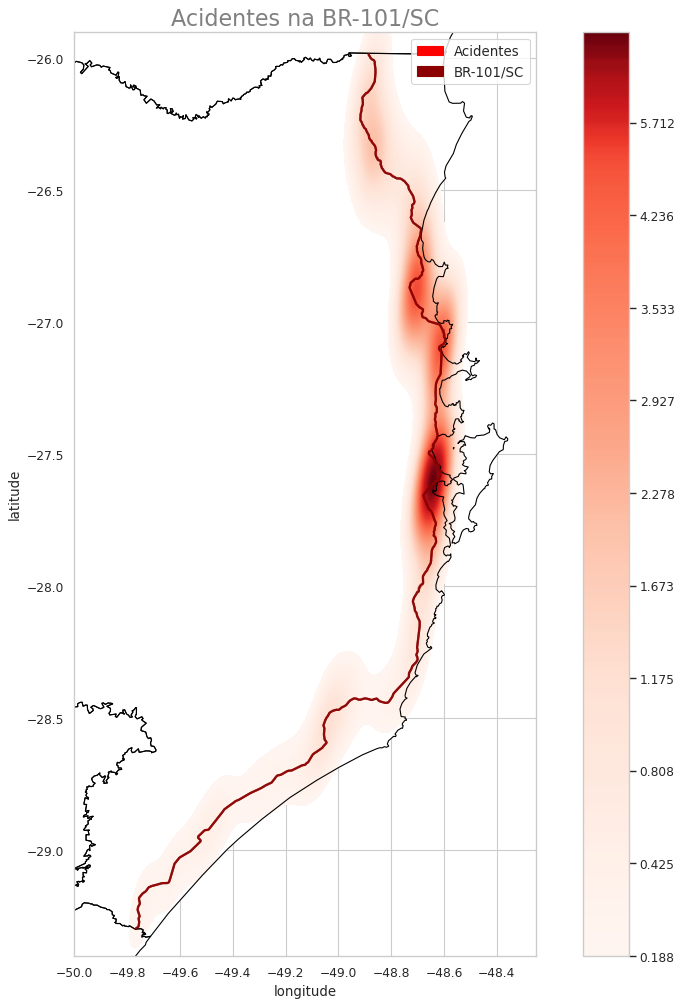

In [ ]:
url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson'
br_states = gpd.read_file(url)

fig, ax = plt.subplots(figsize=(15, 15), dpi=80)
br_states.boundary.plot(ax=ax, linewidth=1, color='black')  # Plota as bordas dos estados
br_states.plot(ax=ax, color='white')  # Plota os estados

sns.kdeplot(data=br101sc_acidentes_geo_df, x='longitude', y='latitude', fill=True, levels=500, cmap='Reds', ax=ax, cbar=True)
br101sc_linhas_gdf.plot(ax=ax, color='darkred', alpha=0.8, linewidth=2, label='BR-101/SC')

acidentes_patch = mpatches.Patch(color='red', label='Acidentes')
pista_patch = mpatches.Patch(color='darkred', label='BR-101/SC')

plt.legend(handles=[acidentes_patch, pista_patch], fontsize=12, loc='best')
plt.ylim(-29.4, -25.9)
plt.xlim(-50, -48.25)
plt.title('Acidentes na BR-101/SC', fontsize=20, color='gray')
plt.show()

## Salvando os dados da ROdovia masi perigosa par cruzar com os dados do INMET

In [ ]:
br101sc_acidentes_gdf.to_file('../data/ANTT/BR-101-SC/acidentes_br101sc.geojson', driver='GeoJSON')
br101sc_pista_df.to_csv('../data/ANTT/BR-101-SC/pista_principal_br101sc.csv', index=False)

In [ ]:
br101sc_acidentes_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 36722 entries, 0 to 36721
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   n_da_ocorrencia                 36722 non-null  object        
 1   km                              36722 non-null  float64       
 2   trecho                          36722 non-null  object        
 3   sentido                         36722 non-null  object        
 4   tipo_de_acidente                36694 non-null  object        
 5   automovel                       36722 non-null  int64         
 6   bicicleta                       36722 non-null  int64         
 7   caminhao                        36722 non-null  int64         
 8   moto                            36722 non-null  int64         
 9   onibus                          36722 non-null  int64         
 10  outros                          36722 non-null  int64         